# CS 5683 - Big Data Analytics
## Project - 5: BigClamV2.0 for community detection


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import libraries
import os
import shutil
import sys
from operator import add
import itertools
import numpy as np
import networkx as nx
import collections
import random
from sklearn.metrics import recall_score
import time as time
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

font = {'size'   : 14}    
plt.rc('font', **font)

import matplotlib as mpl


In [3]:
path_graph = "/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/YouTube.edgelist"

G = nx.read_edgelist(path_graph, create_using= nx.Graph())

# Print the number of nodes and edges in the graph here (1 Point)
print("The total number of nodes in the graph is: " + str(len(G)))
print("The total number of edges in the graph is: " + str(G.number_of_edges()))

n = len(G)
c = 29

The total number of nodes in the graph is: 7675
The total number of edges in the graph is: 35622


In [ ]:
def initialize_F_seed(G, n, c, filename):
'''
Initialize the matrix F for given communiti files
'''

  initial_community_array = []

  # change this path
  file1 = open(f'/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/{filename}.txt', 'r') 
  Lines = file1.readlines() 
    
  count = 0
  for line in Lines: 
      initial_community_array.append(np.array([int(i) for i in line.strip().split(" ")]))
      count = count + 1

  file1.close()
  F = np.zeros((n,c))
  counter = 0

  # assign Fuc = 1 for given communities
  for community in initial_community_array:
    for node in community:
      F[node,counter] = 1.0
    counter += 1

  K = np.zeros(c)
  start = time.time()

  # iterate ove all nodes and assign the neighours of that node
  # that is locally minimal to the community
  for i in range(n):
    if i % 1000 == 0: # print the node number to see the progress
      print(i)
    for j in range(c):
      S = np.copy(initial_community_array[j])
      
      neighor_indices = [] 
      neighor_indices.append(i)
      for k in G.neighbors(str(i)):
        S = np.append(S,int(k))
        neighor_indices.append(int(k))
      
      SS = set([str(k) for k in S])

      # compute the condictance after adding a node and ite neighbors to community c
      K[j] = nx.conductance(G, SS)

    arg_min = np.argmin(K) # locally minimal community 

    # assign the locally minimal community to the node and all its neighbors
    F[neighor_indices,arg_min] = 1.0 

  print('time = ', time.time() - start)

  # save the matrix F
  # change this path
  np.savez(f'/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/F_{filename}.npz', F = F)

  return F

def initialize_F_random(n, c):
'''
Initialize the matrix F by random initilization method
'''  
  F = np.zeros((n,c))

  for i in range(n):
    r1 = random.randint(1,5)
    for j in range(r1):
      r2 = random.randint(0,28)
      F[i,r2] = 1.0

  # save the matrix F
  # change this path
  np.savez(f'/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/F_random.npz', F = F)

  return F

filename = '20percent_seed_communities'
F_true_seed = initialize_F_seed(G, n, c, filename)

filename = 'neighborhood_seeds'
F_neighbor_seed = initialize_F_seed(G, n, c, filename)

F_random = initialize_F_random(n,c)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
time =  1873.075581073761
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
time =  2029.593416929245


In [5]:
# change this path
# load the saved matrix
data = np.load('/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/F_20percent_seed_communities.npz')
F_true_seed = data['F']
data = np.load('/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/F_neighborhood_seeds.npz')
F_neighbor_seed = data['F']
data = np.load('/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/F_random.npz')
F_random = data['F']

In [6]:
print('20 percent seed initilization : ', np.sum(F_true_seed))
print('Neighbor seed initilization : ', np.sum(F_neighbor_seed))
print('Random initilization : ', np.sum(F_random))

20 percent seed initilization :  18666.0
Neighbor seed initilization :  14861.0
Random initilization :  21948.0


In [8]:
def optimize_matrix(G,F,n,c,n_iters,lr):
'''
Optimize the matrix F using gradient ascent method with BigCLAMv2.0 method
'''
  update_value = np.zeros(n_iters)
  
  for k in range(n_iters):
    # compute the sume of all nodes at the begining
    initial_sum = np.sum(F,axis=0)

    # iterate for each row of the column F
    for i in range(n):
      fu = np.copy(F[i,:])
      first_term = np.zeros(c)
      neighours_sum = np.zeros(c)

      # iterate over all neighbors of node u
      for j in G.neighbors(str(i)):
        int_j = int(j)
        fv = np.copy(F[int_j,:])

        product = np.sum(fu*fv) # FuFvT

        if product == 0:
          first_term = first_term + fv*0.0
        else:
          first_term = first_term + fv*(np.exp(-product)/(1.0 - np.exp(-product)))
        neighours_sum = neighours_sum + fv
      
      second_term = initial_sum - fu - neighours_sum

      # gradient computation
      gradient = first_term - second_term

      # old value of F for ith row
      fold = np.copy(F[i,:])

      # update ith row of F
      F[i,:] = F[i,:] + lr*gradient      
      F[i,:] = np.where(F[i,:]<0, 0.00001, F[i,:])

      # store the maximum value of change in F amongst all nodes
      if np.linalg.norm(fold - F[i,:]) > update_value[k]:
        update_value[k] = np.linalg.norm(fold - F[i,:])

    if k%50 == 0:
      print(k, update_value[k])

  return F, update_value


In [9]:
n_iters = 400
lr = 0.0001
F_true_seed_optimized, update_value_true_seed = optimize_matrix(G,F_true_seed,n,c,n_iters,lr)

0 0.6921014583493202
50 0.023160492447236104
100 0.015617903361251795
150 0.01251555882360773
200 0.010703803791800652
250 0.009902020402237607
300 0.009200120568299927
350 0.007932267392996047


In [10]:
n_iters = 400
lr = 0.0001
F_neighbor_seed_optimized, update_value_neighbor_seed = optimize_matrix(G,F_neighbor_seed,n,c,n_iters,lr)

0 0.8313079312206066
50 47.382792887333366
100 94.4379955480301
150 94.68686630405186
200 16.763779291458295
250 32.85882954037308
300 30.319806770592425
350 22.242097688532095


In [11]:
n_iters = 400
lr = 0.0001
F_random_optimized, update_value_random = optimize_matrix(G,F_random,n,c,n_iters,lr)

0 763830.2145903227
50 780.0308776987245
100 458.3582234876055
150 1618.137794993129
200 375.7884639722478
250 621.6386754015535
300 673.2137250057646
350 384.43186481244504


The below plot shows the maximum value of change in the ith row of F from one iteration to another. At each iteration, the change in the value of F is computed for each row and its maximum value is stored. This can give us an indication about the convergence of the BigClam algorithm for optimiozation of F. 

We can observe that the initilization of the matrix F with 20% seed communities is the most accurate method of initilization. The update in the value of F decreases consatntly with an increase in the nuber of iterations. For other two methods, the change in the value of F drops in first few iterationsa and after that it keeps on oscillation about some value till we iterate.  

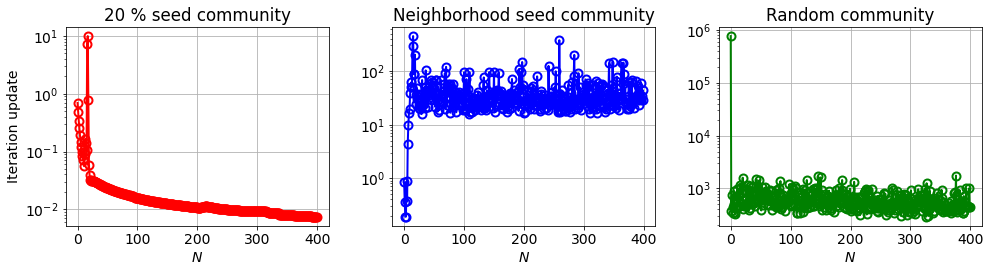

In [12]:
fig, ax = plt.subplots(1,3,figsize=(14,4))

axs = ax.flat

axs[0].semilogy(update_value_true_seed, 'ro-', lw=2, ms=8, mew=2, fillstyle='none',  label='Iteration update')
axs[1].semilogy(update_value_neighbor_seed, 'bo-', lw=2, ms=8, mew=2, fillstyle='none',  label='Iteration update')
axs[2].semilogy(update_value_random, 'go-', lw=2, ms=8, mew=2, fillstyle='none',  label='Iteration update')

for i in range(3):
  axs[i].grid()
  axs[i].set_xlabel('$N$')
  if i == 0:
    axs[i].set_ylabel('Iteration update')

axs[0].set_title('20 % seed community')
axs[1].set_title('Neighborhood seed community')
axs[2].set_title('Random community')

fig.tight_layout()
plt.show()

In [13]:
epsilon = 1.0e-8
delta = np.sqrt(-np.log(1.0 - epsilon))

print(delta)

0.00010000000050123797


In [14]:
ground_truth_community_array = []

# change this path
file1 = open('/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/groundtruth_communities.txt', 'r') 
Lines = file1.readlines() 
  
count = 0
for line in Lines: 
    ground_truth_community_array.append(np.array([int(i) for i in line.strip().split(" ")]))
    count = count + 1

file1.close()

y_true = np.zeros((n,c))
counter = 0
for community in ground_truth_community_array:
  for node in community:
    y_true[node, counter] = 1.0
  counter = counter + 1

In [15]:
y_pred_true_seed = np.zeros((n,c))
y_pred_neighbor_seed = np.zeros((n,c))
y_pred_random = np.zeros((n,c))

for i in range(n):
  pred_community = np.where(F_true_seed_optimized[i,:] > delta)
  for j in pred_community[0]:
    y_pred_true_seed[i,j] = 1.0

  pred_community = np.where(F_neighbor_seed[i,:] > delta)
  for j in pred_community[0]:
    y_pred_neighbor_seed[i,j] = 1.0
  
  pred_community = np.where(F_random[i,:] > delta)
  for j in pred_community[0]:
    y_pred_random[i,j] = 1.0

In [63]:
# write predicted communities for 20% initilization
my_list = []
for j in range(c):
  item = []
  for i in range(n):
    if y_pred_true_seed[i,j] == 1.0:
      item.append(i)
  my_list.append(item)

# change this path
with open('/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/predicted_community_20percent_seed.txt', 'w') as f:
    for item in my_list:
      s = ", ".join(map(str, item))
      f.write(s +"\n")

f.close()

In [ ]:
# write predicted communities for neighborhood initilization
my_list = []
for j in range(c):
  item = []
  for i in range(n):
    if y_pred_neighbor_seed[i,j] == 1.0:
      item.append(i)
  my_list.append(item)

# change this path
with open('/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/predicted_community_neighbor_seed.txt', 'w') as f:
    for item in my_list:
      s = ", ".join(map(str, item))
      f.write(s +"\n")

f.close()

In [ ]:
# write predicted communities for random initilization
my_list = []
for j in range(c):
  item = []
  for i in range(n):
    if y_pred_random[i,j] == 1.0:
      item.append(i)
  my_list.append(item)

# change this path
with open('/content/drive/MyDrive/Coursework/CS 5683_Big_Data/Project-5/predicted_community_random.txt', 'w') as f:
    for item in my_list:
      s = ", ".join(map(str, item))
      f.write(s +"\n")

f.close()

In [46]:
recall_true_seed = 0.0

ground_set = set([i for i in range(c)])

for i in range(c):
  rc_list = []
  for j in ground_set:
    rc = recall_score(y_true[:,j], y_pred_true_seed[:,i])
    rc_list.append(rc)
    arg_max = np.argmax(rc_list)
  recall_true_seed = recall_true_seed + np.max(rc_list)

  ground_set = ground_set.difference(set([list(ground_set)[arg_max]]))

recall_true_seed = recall_true_seed/c

In [47]:
recall_neighbor_seed = 0.0
ground_set = set([i for i in range(c)])

for i in range(c):
  rc_list = []
  for j in ground_set:
    rc = recall_score(y_true[:,j], y_pred_neighbor_seed[:,i])
    rc_list.append(rc)
    arg_max = np.argmax(rc_list)
  recall_neighbor_seed = recall_neighbor_seed + np.max(rc_list)

  ground_set = ground_set.difference(set([list(ground_set)[arg_max]]))

recall_neighbor_seed = recall_neighbor_seed/c

In [48]:
recall_random = 0.0
ground_set = set([i for i in range(c)])

for i in range(c):
  rc_list = []
  for j in ground_set:
    rc = recall_score(y_true[:,j], y_pred_random[:,i])
    rc_list.append(rc)
    arg_max = np.argmax(rc_list)
  recall_random = recall_random + np.max(rc_list)

  ground_set = ground_set.difference(set([list(ground_set)[arg_max]]))

recall_random = recall_random/c

In [49]:
print('20 % seed community: ', np.round(recall_true_seed, 4))
print('Neighborhood seed community: ', np.round(recall_neighbor_seed, 4))
print('Random community : ', np.round(recall_random, 4))


20 % seed community:  0.8593
Neighborhood seed community:  0.5262
Random community :  0.1949


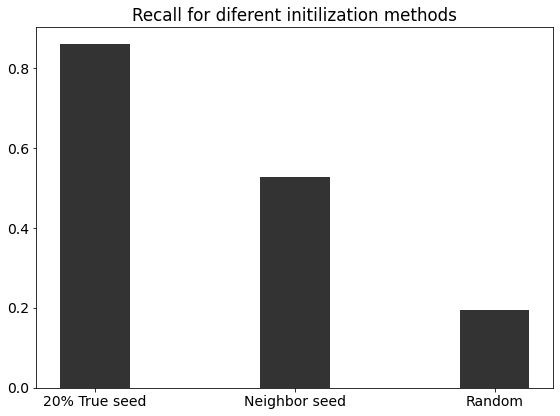

In [50]:
data = {'20% True seed': recall_true_seed, 'Neighbor seed': recall_neighbor_seed, 'Random': recall_random}
names = list(data.keys())
values = list(data.values())

x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=True)
axs.bar(names, values, width, color='k', alpha=0.8)
plt.title('Recall for diferent initilization methods')

fig.tight_layout()
plt.show()

From the above bar chart, we can clearly see the importance of initilization method for the BigClamV2.0 allgorithm. When we use 20% nodes from the ground truth for initilizing F, we can get the recall around 0.86. With random initilization, the recall is around 0.19.  


# Due Date: Nov. 29 at 11:59pm